<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/CatBoost_ChessGames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [24]:
import kagglehub
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Step 1: Download dataset from KaggleHub
path = kagglehub.dataset_download("datasnaek/chess")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chess


In [13]:
# Step 2: Load the CSV data
csv_file = f"{path}/games.csv"
df = pd.read_csv(csv_file)

In [14]:
# Step 3: Preview the data
print(df.head())
print(df['winner'].value_counts())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

In [15]:
# Step 4: Basic preprocessing
# Drop columns that aren't useful or leak information (e.g., 'moves' or 'victory_status' can be removed for now)
df = df.drop(columns=['id', 'moves', 'victory_status'])  # optional: try with/without these

# Convert target to numerical labels
df['winner'] = df['winner'].map({'white': 0, 'black': 1, 'draw': 2})

# Identify categorical features
cat_features = df.select_dtypes(include=['object']).columns.tolist()

In [16]:
# Step 5: Train-test split
X = df.drop(columns=['winner'])
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
# Step 6: Create CatBoost Pool objects
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [22]:
# Step 7: Train CatBoost model
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.5742241	test: 0.5752742	best: 0.5752742 (0)	total: 174ms	remaining: 52s
50:	learn: 0.6523744	test: 0.6597707	best: 0.6617647 (48)	total: 7.92s	remaining: 38.7s
100:	learn: 0.6705098	test: 0.6779661	best: 0.6792124 (97)	total: 20s	remaining: 39.3s
150:	learn: 0.7103328	test: 0.7081256	best: 0.7081256 (150)	total: 29.6s	remaining: 29.2s
200:	learn: 0.7487224	test: 0.7330508	best: 0.7345464 (198)	total: 35s	remaining: 17.2s
250:	learn: 0.7755827	test: 0.7544865	best: 0.7549850 (247)	total: 42.2s	remaining: 8.23s
299:	learn: 0.8011342	test: 0.7769192	best: 0.7769192 (299)	total: 47.4s	remaining: 0us

bestTest = 0.7769192423
bestIteration = 299



In [23]:
# Step 8: Evaluate the model
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['white', 'black', 'draw']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: Save the model
model.save_model("catboost_chess_model.cbm")


Accuracy: 0.7769192422731804

Classification Report:
              precision    recall  f1-score   support

       white       0.78      0.82      0.80      2000
       black       0.77      0.80      0.78      1822
        draw       0.81      0.12      0.20       190

    accuracy                           0.78      4012
   macro avg       0.79      0.58      0.60      4012
weighted avg       0.78      0.78      0.76      4012


Confusion Matrix:
[[1646  354    0]
 [ 368 1449    5]
 [  97   71   22]]


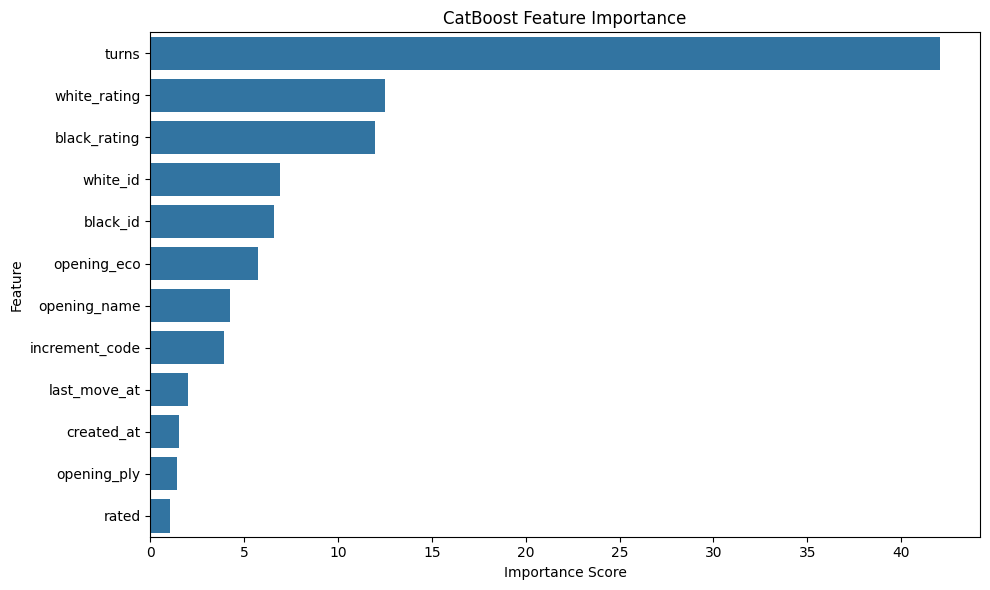

In [25]:
# Step 9: Visualize feature importance
feature_importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importances.sort_values(by='Importances', ascending=False))
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

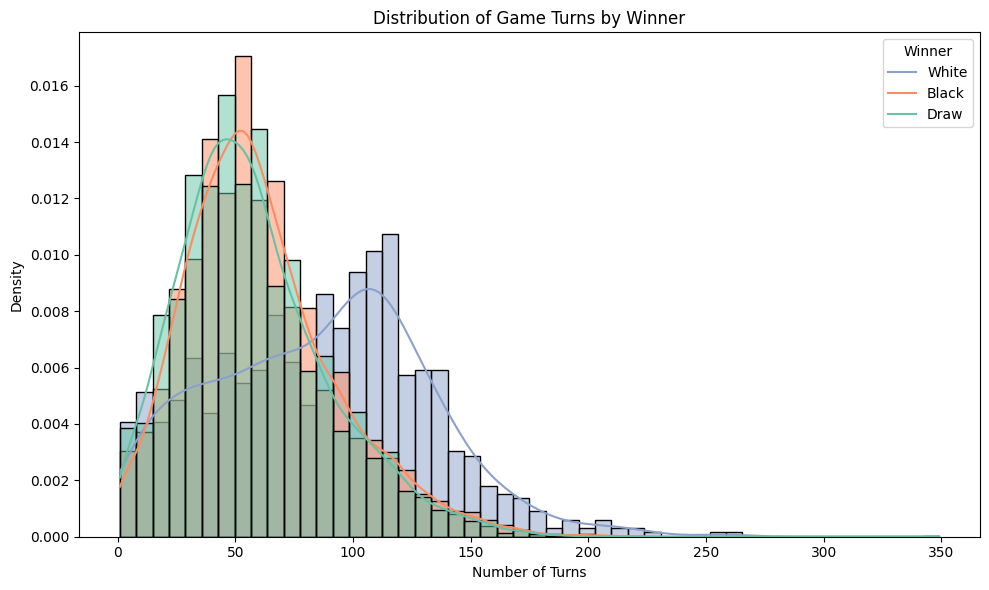

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='turns', hue='winner', bins=50, kde=True, palette='Set2', stat='density', common_norm=False)
plt.title("Distribution of Game Turns by Winner")
plt.xlabel("Number of Turns")
plt.ylabel("Density")
plt.legend(title="Winner", labels=["White", "Black", "Draw"])
plt.tight_layout()
plt.show()

In [27]:
turns_stats = df.groupby('winner')['turns'].agg(['mean', 'std', 'median', 'count'])
turns_stats.index = ['White', 'Black', 'Draw']
print(turns_stats)

            mean        std  median  count
White  57.790221  32.193353    53.0  10001
Black  60.724388  32.369867    56.0   9107
Draw   86.157895  45.897861    89.0    950


<ipython-input-28-b20510586bb1>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_outcomes = df.groupby('turns_bin')['winner'].value_counts(normalize=True).unstack().fillna(0)


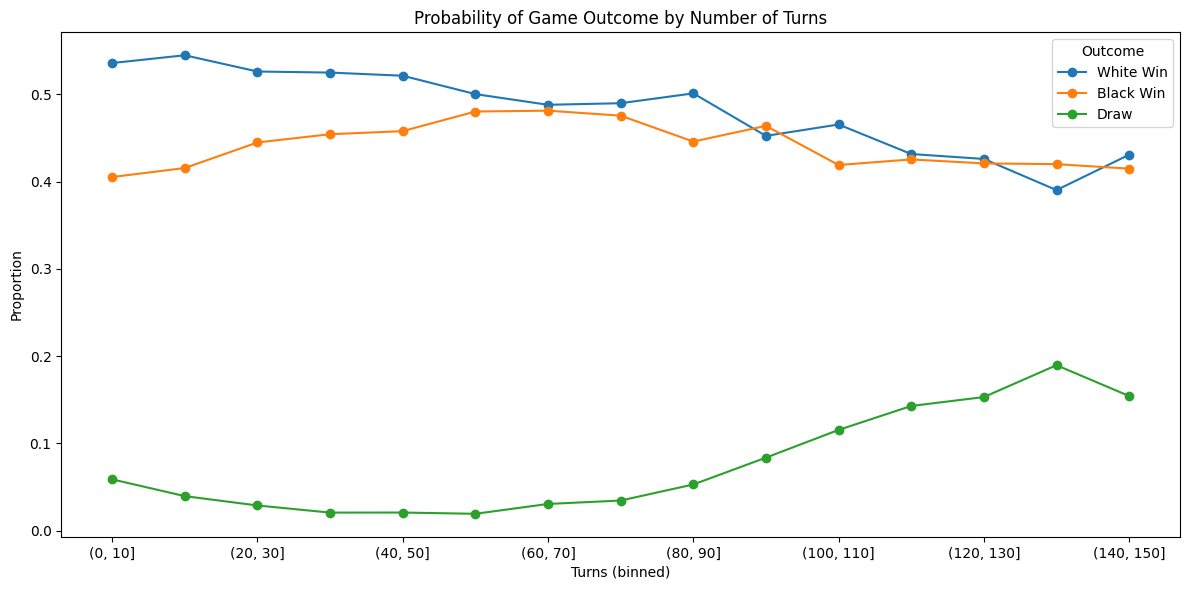

In [28]:
# Bin turns
df['turns_bin'] = pd.cut(df['turns'], bins=range(0, 151, 10))  # bins of 10 turns up to 150

# Compute outcome proportions per bin
bin_outcomes = df.groupby('turns_bin')['winner'].value_counts(normalize=True).unstack().fillna(0)

# Plot
bin_outcomes.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Probability of Game Outcome by Number of Turns")
plt.xlabel("Turns (binned)")
plt.ylabel("Proportion")
plt.legend(['White Win', 'Black Win', 'Draw'], title='Outcome')
plt.tight_layout()
plt.show()

In [30]:
# Calculate total games per opening
opening_counts = df['opening_name'].value_counts()

# Only keep openings played at least N times (e.g., 50) for meaningful stats
min_games = 50
popular_openings = opening_counts[opening_counts >= min_games].index
df_filtered = df[df['opening_name'].isin(popular_openings)]

# Group by opening and winner to count outcomes
opening_win_counts = df_filtered.groupby(['opening_name', 'winner']).size().unstack(fill_value=0)

# Rename columns to the original string labels for clarity
opening_win_counts = opening_win_counts.rename(columns={0: 'white', 1: 'black', 2: 'draw'})

# Compute total and win rates
opening_win_counts['total_games'] = opening_win_counts.sum(axis=1)
# Access columns using the renamed string labels
opening_win_counts['white_win_rate'] = opening_win_counts['white'] / opening_win_counts['total_games']
opening_win_counts['black_win_rate'] = opening_win_counts['black'] / opening_win_counts['total_games']

# Sort by win rate
top_white_openings = opening_win_counts.sort_values(by='white_win_rate', ascending=False).head(10)
top_black_openings = opening_win_counts.sort_values(by='black_win_rate', ascending=False).head(10)

print("\n🏁 Top 10 Openings for White (by win rate):")
print(top_white_openings[['white_win_rate', 'total_games']])

print("\n🛡️ Top 10 Openings for Black (by win rate):")
print(top_black_openings[['black_win_rate', 'total_games']])


🏁 Top 10 Openings for White (by win rate):
winner                                              white_win_rate  \
opening_name                                                         
Zukertort Opening: Queen's Gambit Invitation              0.698113   
King's Knight Opening                                     0.689655   
King's Pawn Game: Busch-Gass Gambit                       0.672414   
Queen's Gambit Refused: Marshall Defense                  0.661417   
Elephant Gambit                                           0.660714   
Queen's Pawn                                              0.658915   
Nimzowitsch Defense: Kennedy Variation |  Links...        0.653846   
Philidor Defense #3                                       0.641414   
Bishop's Opening: Berlin Defense                          0.638298   
Scandinavian Defense: Mieses-Kotroc Variation             0.633205   

winner                                              total_games  
opening_name                                     

<ipython-input-31-69e158460431>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_white_openings.reset_index(), x='white_win_rate', y='opening_name', palette='Greens_r')


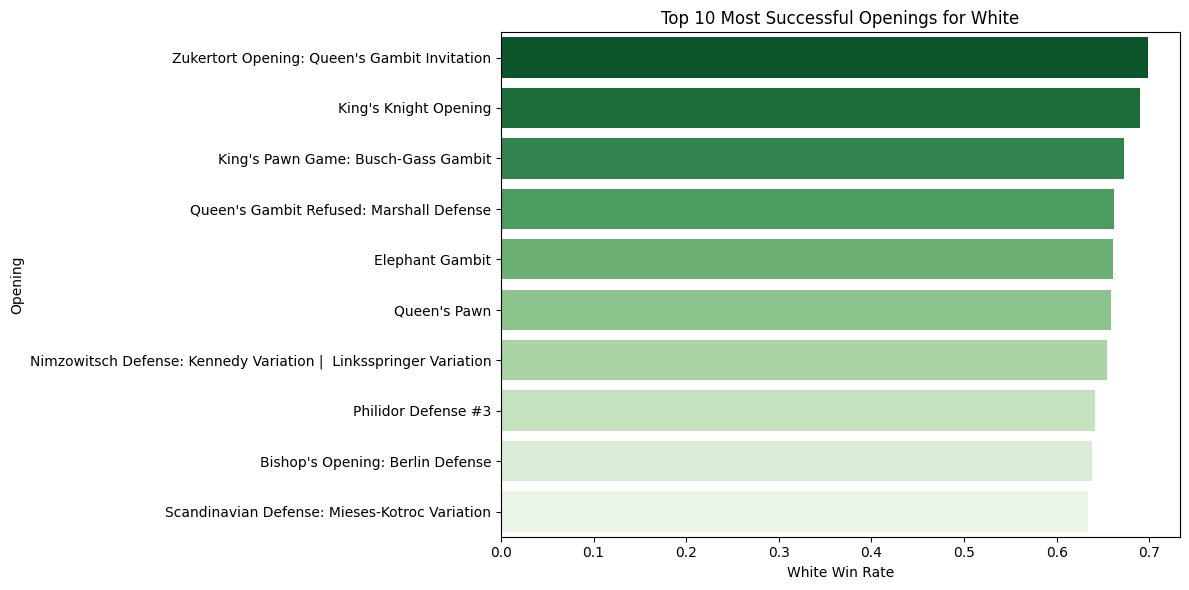

<ipython-input-31-69e158460431>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_black_openings.reset_index(), x='black_win_rate', y='opening_name', palette='Blues_r')


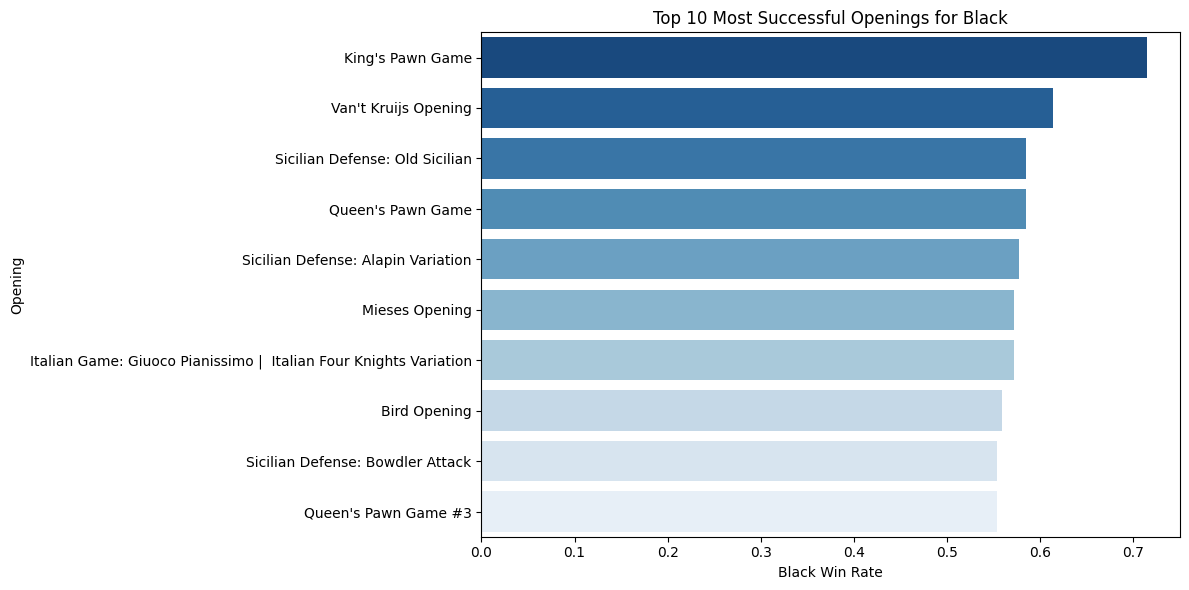

In [31]:
# Barplot for White
plt.figure(figsize=(12, 6))
sns.barplot(data=top_white_openings.reset_index(), x='white_win_rate', y='opening_name', palette='Greens_r')
plt.title("Top 10 Most Successful Openings for White")
plt.xlabel("White Win Rate")
plt.ylabel("Opening")
plt.tight_layout()
plt.show()

# Barplot for Black
plt.figure(figsize=(12, 6))
sns.barplot(data=top_black_openings.reset_index(), x='black_win_rate', y='opening_name', palette='Blues_r')
plt.title("Top 10 Most Successful Openings for Black")
plt.xlabel("Black Win Rate")
plt.ylabel("Opening")
plt.tight_layout()
plt.show()